In [1]:
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

# Generator

In [5]:
class Generator(nn.Module):
    def __init__(self, z_dim=20,image_size=64):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size*8, kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size*8),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size*8, image_size*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size*4),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size*4, image_size*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size*2),
            nn.ReLU(inplace=True))
        
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size*2, image_size*1, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh())

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out

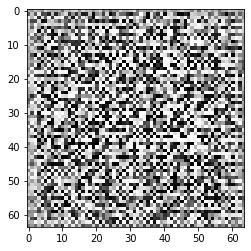

In [6]:
# Check
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20,image_size=64)
input_z = torch.randn(1,20)

input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

fake_images = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

# Discriminator

In [8]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out

In [9]:
# Check
D = Discriminator(z_dim=20, image_size=64)

input_z = torch.randn(1,20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)

d_out = D(fake_images)

print(nn.Sigmoid()(d_out))

tensor([[[[0.4992]]]], grad_fn=<SigmoidBackward>)


# Loss Function

In [12]:
# x is undefined (imaginary implementation)

# mini_batch_size = 2
# label_real = torch.full((mini_batch_size,), 1)

# label_fake = torch.full((mini_batch_size,), 0)

# criterion = nn.BCEWithLogitsLoss(reduction='mean')

# d_out_real = D(x)

# input_z = torch.randn(mini_batch_size, 20)
# input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
# fake_images = G(input_z)
# d_out_fake = D(fake_images)

# d_loss_real = criterion(d_out_real.view(-1), label_real)
# d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
# d_loss = d_loss_real + d_loss_fake

In [13]:
# x is undefined (imaginary implementation)

# input_z = torch.randn(mini_batch_size, 20)
# input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
# fake_images = G(input_z)
# d_out_fake = D(fake_images)

# g_loss = criterion(d_out_fake.view(-1), label_real)

# Data Loader

In [15]:
def make_datapath_list():

    train_img_list = list()

    for img_idx in range(200):
        img_path = "./data/img_78/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/img_78/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list

class ImageTransform():

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)

class GAN_Img_Dataset(data.Dataset):
    
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):

        img_path = self.file_list[index]
        img = Image.open(img_path)

        img_transformed = self.transform(img)

        return img_transformed

train_img_list = make_datapath_list()

mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(file_list=train_img_list, transform=ImageTransform(mean, std))

batch_size = 64

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

batch_iterator = iter(train_dataloader)

images = next(batch_iterator)
print(images.size())

torch.Size([64, 1, 64, 64])


In [16]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

G.apply(weights_init)
D.apply(weights_init)

print("Network initialize completed")

Network initialize completed


In [28]:
def train_model(G, D, dataloader, num_epochs):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    criterion = nn.BCEWithLogitsLoss(reduction='mean')
    
    z_dim = 20
    mini_batch_size = 64

    G.to(device)
    D.to(device)

    G.train()
    D.train()

    torch.backends.cudnn.benchmark = True

    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    iteration = 1
    logs = []

    for epoch in range(num_epochs):

        t_epoch_start = time.time()
        epoch_g_loss = 0.0
        epoch_d_loss = 0.0

        print('-----------------')
        print(f"Epoch{epoch}/{num_epochs}")
        print('-----------------')
        print(' (train) ')

        for images in dataloader:
            # If batch size is 0, BatchNormLayer dont work 
            if images.size()[0] == 1:
                continue
            
            images = images.to(device)
            # make label
            mini_batch_size = images.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            #######################
            # Discriminator train #
            #######################
            d_out_real = D(images)
            # make fake images & predict
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)
            # calculate loss
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake
            # back propagation
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            ###################
            # Generator train #
            ###################
            # make fake imagaes & predict
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)
            # calculate loss
            g_loss = criterion(d_out_fake.view(-1), label_real)
            # back propagation
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
            #############
            # Recording #
            #############
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        t_epoch_finish = time.time()
        print('-------------')
        print(f"epoch {epoch} || Epoch_D_Loss:{epoch_d_loss/batch_size:.4f} || Epoch_G_Loss:{epoch_g_loss/batch_size:.4f}")
        print(f"timer: {t_epoch_finish - t_epoch_start:.4f}")
        t_epoch_start = time.time()

    return G, D

In [29]:
num_epochs = 200
G_update, D_update  = train_model(G, D, dataloader = train_dataloader, num_epochs=num_epochs)

 || Epoch_D_Loss:0.0891 || Epoch_G_Loss:0.2081
timer: 12.9032
-----------------
Epoch61/200
-----------------
 (train) 
-------------
epoch 61 || Epoch_D_Loss:0.0779 || Epoch_G_Loss:0.2049
timer: 12.6031
-----------------
Epoch62/200
-----------------
 (train) 
-------------
epoch 62 || Epoch_D_Loss:0.0886 || Epoch_G_Loss:0.2202
timer: 12.6462
-----------------
Epoch63/200
-----------------
 (train) 
-------------
epoch 63 || Epoch_D_Loss:0.0815 || Epoch_G_Loss:0.2054
timer: 12.9088
-----------------
Epoch64/200
-----------------
 (train) 
-------------
epoch 64 || Epoch_D_Loss:0.0954 || Epoch_G_Loss:0.1767
timer: 12.6882
-----------------
Epoch65/200
-----------------
 (train) 
-------------
epoch 65 || Epoch_D_Loss:0.0964 || Epoch_G_Loss:0.2086
timer: 12.5731
-----------------
Epoch66/200
-----------------
 (train) 
-------------
epoch 66 || Epoch_D_Loss:0.0830 || Epoch_G_Loss:0.1917
timer: 12.7830
-----------------
Epoch67/200
-----------------
 (train) 
-------------
epoch 67 || Ep

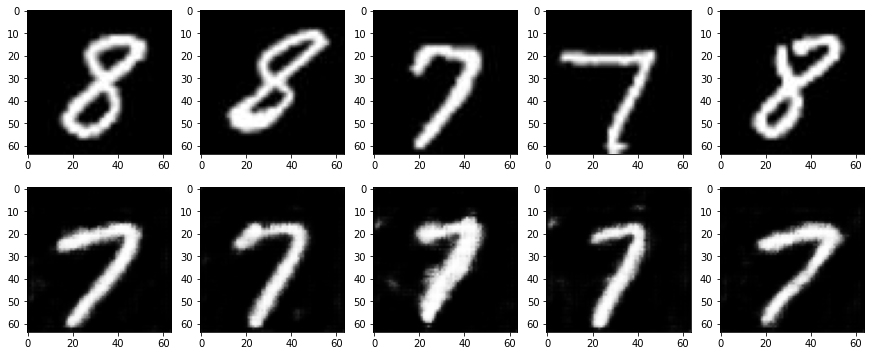

In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

G_update.eval()
fake_images = G_update(fixed_z.to(device))

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i][0].cpu().detach().numpy(), 'gray')

    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')